<a href="https://colab.research.google.com/github/Natural-Language-Processing-YU/M3_Assignment/blob/main/scripts/m3_assignment_part_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part III
Using the previous two tutorials, please answer the following using an encorder-decoder approach and an LSTM compared approach.

Please create a transformer-based classifier for English name classification into male or female.

There are several datasets for name for male or female classification. In subseuqent iterations, this could be expanded to included more classifications.

Below is the source from NLTK, which only has male and female available but could be used for the purposes of this assignment.

```
names = nltk.corpus.names
names.fileids()
['female.txt', 'male.txt']
male_names = names.words('male.txt')
female_names = names.words('female.txt')
[w for w in male_names if w in female_names]
['Abbey', 'Abbie', 'Abby', 'Addie', 'Adrian', 'Adrien', 'Ajay', 'Alex', 'Alexis',
'Alfie', 'Ali', 'Alix', 'Allie', 'Allyn', 'Andie', 'Andrea', 'Andy', 'Angel',
'Angie', 'Ariel', 'Ashley', 'Aubrey', 'Augustine', 'Austin', 'Averil', ...]
```

In [ ]:
# ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
# None
# ### END CODE HERE ###

In [ ]:
### TRANSFORMER

## TRANSFORMER

In [ ]:
!pip install --upgrade transformers
!pip install -q tensorflow==2.2
!pip install -q keras==2.3.1

In [15]:

from transformers import BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import nltk
nltk.download('names')
import tensorflow as tf
import pandas as pd
import sklearn
import unicodedata
import numpy as np
import random
import re
import nltk
from nltk.corpus import movie_reviews
import tensorflow as tf
import tensorflow.keras as keras
import transformers

from transformers import BertTokenizer, TFBertForSequenceClassification

names = nltk.corpus.names
male_names = [name.lower() for name in names.words('male.txt')]
female_names = [name.lower() for name in names.words('female.txt')]

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!


In [16]:
data = [(name, 0) for name in male_names] + [(name, 1) for name in female_names]
names, labels = zip(*data)

In [17]:
names_train, names_test, labels_train, labels_test = train_test_split(names, labels, test_size=0.2, random_state=42)


In [18]:
num_classes = 2

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
def convert_example_to_feature(review):
  return bert_tokenizer.encode_plus(review,
                add_special_tokens = True,     # add [CLS], [SEP]
                max_length = 512,              # max length of the text that can go to BERT
                padding='max_length',
                truncation=True,
                return_attention_mask = True,  # add attention mask to not focus on pad tokens
              )


In [19]:
# map to the expected input to TFBertForSequenceClassification
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

def encode_examples(ds):
  # prepare list, so that we can build up final TensorFlow dataset from slices.
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []
  for review, label in ds:
    bert_input = convert_example_to_feature(review)
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])

  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [20]:
batch_size = 8

In [21]:
y_train = np.array(labels_train)
y_test = np.array(labels_test)

In [8]:
ds_train = zip(names_train, y_train)
ds_test = zip(names_test, y_test)
ds_train_encoded = encode_examples(ds_train).shuffle(len(names_train)).batch(batch_size)
ds_test_encoded = encode_examples(ds_test).batch(batch_size)

In [22]:
model_save_path = './sentiment-analysis-using-bert-keras/models/bert_model.h5'

path = "./sentiment-analysis-using-bert-keras/models/"

## Initialize pre-built BERT-based classifier from transformers
bert_model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=2)

bert_model.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_75 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
import tensorflow.compat.v1 as tf

In [26]:
learning_rate = 2e-5
number_of_epochs = 2

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_model.compile(loss=loss,
                   optimizer=optimizer,
                   metrics=metric)

In [28]:
history = bert_model.fit(ds_train_encoded,
                         batch_size=batch_size,
                         epochs=2,
                         validation_data=ds_test_encoded)

Epoch 1/2
795/795 [==============================] - 820s 1s/step - loss: 0.3121 - accuracy: 0.8722 - val_loss: 0.3637 - val_accuracy: 0.8332
Epoch 2/2
795/795 [==============================] - 826s 1s/step - loss: 0.2134 - accuracy: 0.9158 - val_loss: 0.3611 - val_accuracy: 0.8609


In [29]:
bert_model.evaluate(ds_test_encoded,
                    batch_size=batch_size)

199/199 [==============================] - 68s 341ms/step - loss: 0.3611 - accuracy: 0.8609


[0.3610846996307373, 0.8609188199043274]

In [30]:
y_test_pred = bert_model.predict(ds_test_encoded,
                                 batch_size=batch_size)

199/199 [==============================] - 76s 338ms/step


In [31]:
y_test_pred_class = y_test_pred[0].argmax(axis=1)

In [32]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6), dpi=150)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j,
                     i,
                     "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j,
                     i,
                     "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(
        accuracy, misclass))
    plt.show()

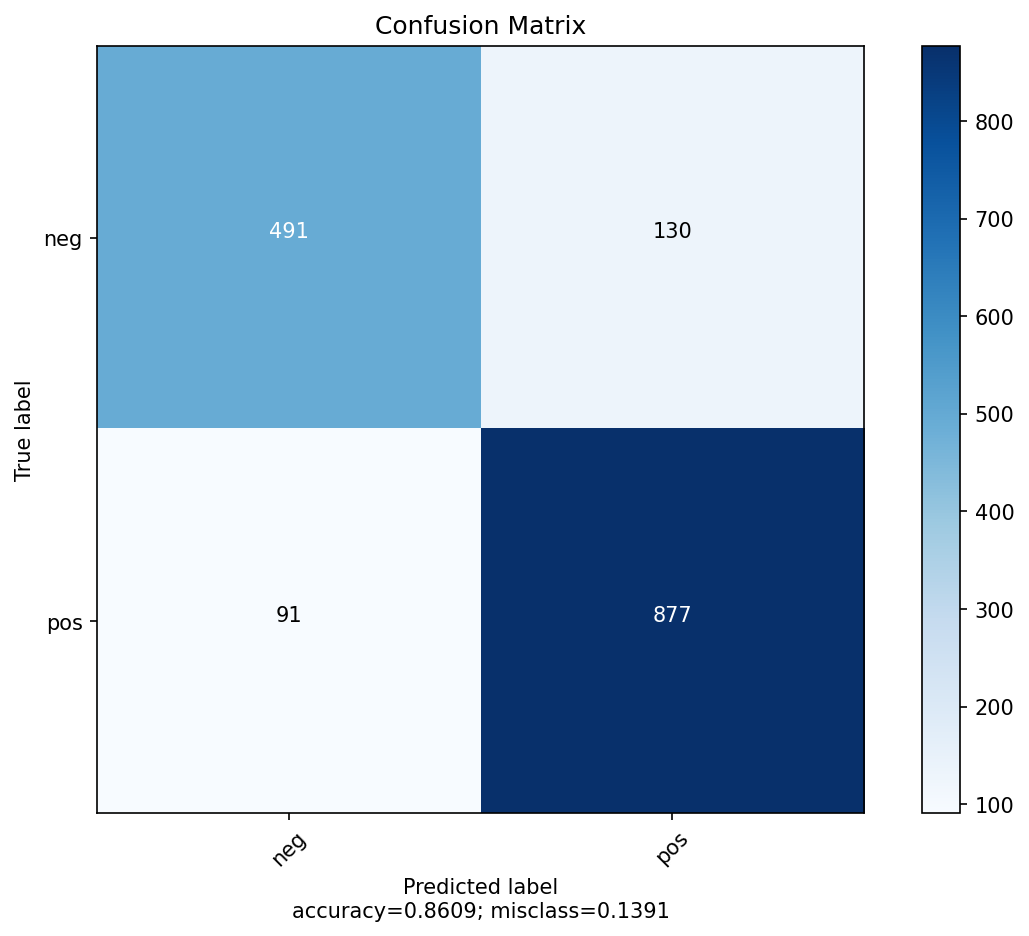

In [33]:
cm = sklearn.metrics.confusion_matrix(y_test,
                                      y_test_pred_class,
                                      normalize=None)
plot_confusion_matrix(cm,
                      normalize=False,
                      target_names=['neg', 'pos'],
                      title="Confusion Matrix")

## LSTM

In [ ]:
!pip install --upgrade tensorflow

In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

import nltk
nltk.download('names')
from nltk.corpus import names
male_names = names.words('male.txt')
female_names = names.words('female.txt')
all_names = male_names + female_names
labels = [0]*len(male_names) + [1]*len(female_names)

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!


In [40]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(all_names)

sequences = tokenizer.texts_to_sequences(all_names)

max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
X_train,X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)


In [39]:
padded_sequences.shape

(7944, 15)

In [42]:
labels = np.array(labels)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=32, input_length=max_length),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6360 - loss: 0.6541 - val_accuracy: 0.6910 - val_loss: 0.5873
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7181 - loss: 0.5609 - val_accuracy: 0.7055 - val_loss: 0.5641
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7503 - loss: 0.5134 - val_accuracy: 0.7225 - val_loss: 0.5500
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7532 - loss: 0.5051 - val_accuracy: 0.7464 - val_loss: 0.5218
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7575 - loss: 0.5011 - val_accuracy: 0.7577 - val_loss: 0.4924
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7781 - loss: 0.4802 - val_accuracy: 0.7684 - val_loss: 0.4822
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7769 - loss: 0.4836 - val_accuracy: 0.7690 - val_loss: 0.4795
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7911 - loss: 0.4553 - val_accuracy

In [43]:
from sklearn.metrics import confusion_matrix

y_pred = (model.predict(X_test) > 0.5).astype("int32")

conf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Confusion Matrix:
[[375 246]
 [ 99 869]]


## transformers show better results than lstm

# References
1. https://arxiv.org/pdf/2102.03692.pdf
2. https://alvinntnu.github.io/NTNU_ENC2045_LECTURES/exercise/13-attention.html
3. https://towardsdatascience.com/deep-learning-gender-from-name-lstm-recurrent-neural-networks-448d64553044
4. https://www.nltk.org/book/ch02.html#sec-lexical-resources